# AI-Agent for Item Generation

## Workshop Overview
Welcome to this hands-on workshop on using **Multi-Agent Systems** with **LangGraph** for intelligent item generation. While RAG systems retrieve and generate based on static documents, agents can reason, plan, use tools, and collaborate to solve complex tasks.

**What You'll Learn:**
- Understanding AI agents: what they are and how they differ from simple LLMs 
- Building autonomous agents that can use tools (web search, calculators, databases)
- Creating multi-agent systems where specialized agents collaborate
- Implementing agent workflows with LangGraph's state management
- Generating high-quality assessment items through agent collaboration
- Best practices for agent orchestration and quality control

### **What Are AI Agents?**
An **AI agent** is an autonomous system that can:
1. **Perceive** its environment (receive inputs and context)
2. **Reason** about what actions to take (plan and decide)
3. **Act** by using tools or generating outputs
4. **Learn** from feedback to improve performance
5. **Knowledge Base** The repository of information the agent uses to make decisions 
6. **Communication** Allows the agent to interact with other agents, systems, or humans.


Think of an agent as an intelligent assistant that doesn't just answer questions—it can:
- Search the internet for current information
- Perform calculations and data analysis
- Break complex tasks into manageable subtasks
- Use multiple tools to accomplish goals
- Verify and improve its own outputs
- Adapt its approach based on results

### **Examples of What AI Agents Can Do:**

**Single Agent Tasks:**
- **Research assistant**: Search academic papers, summarize findings, cite sources
- **Code debugger**: Analyze code, identify errors, suggest fixes, test solutions
- **Travel planner**: Search flights, compare prices, check weather, create itineraries
- **Data analyst**: Query databases, perform calculations, create visualizations
- **Content creator**: Research topics, generate drafts, fact-check, revise
 
**Agent Collaboration:**
- **Software development**: One agent writes code, another tests it, third documents it
- **Research projects**: One agent finds papers, another analyzes them, third writes summaries
- **Customer service**: One agent triages issues, specialists handle specific problems
- **Content creation**: Researcher gathers info, writer creates content, editor refines it
 

### All you need to know about AI Agents

![alt text](<Screenshot 2025-10-12 182936.png>)

 ### **AI Agents for Item Generation?**
# 
Creating high-quality educational assessments requires multiple specialized capabilities:
- **Domain expertise** in the subject area (math, science, etc.)
- **Pedagogical knowledge** of appropriate difficulty levels
- **Current information** from recent developments and research
- **Quality assurance** to ensure accuracy and clarity
- **Iterative refinement** to improve item quality

AI agents solve this by:
1. **Specializing** in different aspects of item generation
2. **Accessing real-time information** through web search tools
3. **Self-correcting** through review and validation
4. **Adapting** to different subjects and difficulty levels
5. **Documenting** their reasoning and sources 

### Understanding Nodes and Edges

Before building our AI agent system, let's understand the fundamental building blocks of LangGraph: **nodes** and **edges**.

**What are Nodes?**

**Nodes** are the individual tasks or agents in your workflow. Each node:
Represents a specific function or agent
Receives the current state
Performs an action (generate text, search web, validate, etc.)
Returns updated state

Think of nodes as workers in an assembly line, each with a specific job.

**Example Node Types:**

**Research Node**: Searches for information

**Generator Node**: Creates content

**Validator Node**: Checks quality

**Editor Node**: Improves content


### **What are Edges?**
 
 **Edges** define how nodes connect and when workflow moves from one node to another:
 

# Node and Edges 

![alt text](<Screenshot 2025-10-12 184537.png>)

In [14]:
import os
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END
import operator

# Load environment variables
load_dotenv()

# Verify API keys
groq_key = os.getenv("GROQ_API_KEY")
tavily_key = os.getenv("TAVILY_API_KEY")

In [2]:
# ## 2. Initialize Language Model

# Initialize LLM for all agents
llm = ChatGroq(
    model="openai/gpt-oss-120b",
    temperature=0.7,
    max_tokens=1000
)

print("✅ Language model initialized")
print(f"   Model: openai/gpt-oss-120b")
print(f"   Temperature: 0.7")

✅ Language model initialized
   Model: openai/gpt-oss-120b
   Temperature: 0.7


### Agentic Workflow Patterns

Before building our full system, let's understand 

**5 key agentic workflow patterns** with simple examples.

### Pattern 1: Prompt Chaining (Sequential Flow)

**Concept**: Chain multiple prompts together where each step builds on the previous one.

**Flow**: Step 1 → Step 2 → Step 3 → Result

**When to use**: When tasks need to happen in sequence, each depending on the previous output.

**Generating Reading Passage**

**Item Generation Example**: Generate → Improve → Polish

In [6]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

# Simple state for prompt chaining
class ChainState(TypedDict):
    topic: str
    draft: str
    improved: str
    final: str

# Node 1: Generate draft
def generate_draft(state: ChainState) -> ChainState:
    """First step: Generate initial passage"""
    prompt = f"Create a simple 8th grade Reading passage about {state['topic']}."
    response = llm.invoke(prompt)
    state["draft"] = response.content
    return state

# Node 2: Improve draft
def improve_draft(state: ChainState) -> ChainState:
    """Second step: Improve the draft"""
    prompt = f"Improve the generated passage for clarity:\n{state['draft']} aligned to 8th grade reading level."
    response = llm.invoke(prompt)
    state["improved"] = response.content
    return state

# Node 3: MCQ Question Generator
def generate_mcq(state: ChainState) -> ChainState:
    """Third step: Generate MCQ Question"""
    prompt = f"Create a multiple choice question based on the passage:\n{state['improved']}"
    response = llm.invoke(prompt)
    state["final"] = response.content
    return state

# Build prompt chaining graph
chain_graph = StateGraph(ChainState)
chain_graph.add_node("generate", generate_draft)
chain_graph.add_node("improve", improve_draft)
chain_graph.add_node("mcq", generate_mcq)

# Sequential edges
chain_graph.add_edge(START, "generate")
chain_graph.add_edge("generate", "improve")
chain_graph.add_edge("improve", "mcq")
chain_graph.add_edge("mcq", END)

chain_app = chain_graph.compile()

# Test prompt chaining
print("\n🔗 PROMPT CHAINING EXAMPLE")
print("="*60)



result = chain_app.invoke({"topic": "the water cycle"})
print(result["draft"])
print("Final Item:")
print(result["final"])


🔗 PROMPT CHAINING EXAMPLE
**The Water Cycle: Nature’s Endless Journey**

Every drop of water on Earth is part of a giant, never‑ending loop called the water cycle. This cycle moves water from the surface of the planet to the sky and back again, changing its form along the way. Understanding how the water cycle works helps us see why water is always available for plants, animals, and people—even though we never see a “big tank” of it sitting somewhere.

---

### 1. Evaporation – Water Turns to Vapor  

When the Sun shines on oceans, lakes, rivers, and even wet soil, it heats the water. The heat gives water molecules enough energy to break away from the surface and rise into the air as invisible water vapor. This process is called **evaporation**. Even the water in your own sweat or a puddle on a hot day will evaporate and join the air.

---

### 2. Transpiration – Plants Join the Party  

Plants are also part of the cycle. Through tiny openings on their leaves called *stomata*, plants 

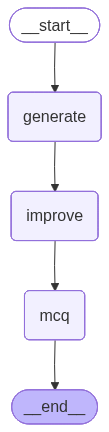

In [8]:
# Show the workflow

from IPython.display import Image, display

display(Image(chain_app.get_graph().draw_mermaid_png()))

### Pattern 2: Parallelization (Concurrent Execution)

**Concept**: Run multiple agents simultaneously, then combine results.

**Flow**: Start → [Agent A, Agent B, Agent C] → Combine → End

**When to use**: When tasks are independent and can run concurrently for speed.

 
 

**Item Generation Example**: Generate multiple item types simultaneously

In [10]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class ParallelState(TypedDict, total=False):  # total=False lets us return partials
    topic: str
    math_item: str
    science_item: str
    history_item: str
    combined_result: str

def generate_math_item(state: ParallelState) -> ParallelState:
    prompt = f"Create ONE math question about {state['topic']} with answer choices A-D and indicate the correct answer."
    response = llm.invoke(prompt)
    return {"math_item": response.content}  # <-- partial update only

def generate_science_item(state: ParallelState) -> ParallelState:
    prompt = f"Create ONE science question about {state['topic']} with answer choices A-D and indicate the correct answer."
    response = llm.invoke(prompt)
    return {"science_item": response.content}  # <-- partial update only

def generate_history_item(state: ParallelState) -> ParallelState:
    prompt = f"Create ONE history question related to {state['topic']} with answer choices A-D and indicate the correct answer."
    response = llm.invoke(prompt)
    return {"history_item": response.content}  # <-- partial update only

def combine_items(state: ParallelState) -> ParallelState:
    combined = f"""
INTERDISCIPLINARY ASSESSMENT SET

Math Item:
{state.get('math_item','')}

Science Item:
{state.get('science_item','')}

History Item:
{state.get('history_item','')}
"""
    return {"combined_result": combined}  # <-- partial update only

parallel_graph = StateGraph(ParallelState)
parallel_graph.add_node("math", generate_math_item)
parallel_graph.add_node("science", generate_science_item)
parallel_graph.add_node("history", generate_history_item)
parallel_graph.add_node("combine", combine_items)

parallel_graph.add_edge(START, "math")
parallel_graph.add_edge(START, "science")
parallel_graph.add_edge(START, "history")
parallel_graph.add_edge("math", "combine")
parallel_graph.add_edge("science", "combine")
parallel_graph.add_edge("history", "combine")
parallel_graph.add_edge("combine", END)

parallel_app = parallel_graph.compile()

print("\n⚡ PARALLELIZATION EXAMPLE")
print("="*60)
result = parallel_app.invoke({"topic": "energy"})
print(result["combined_result"])



⚡ PARALLELIZATION EXAMPLE

INTERDISCIPLINARY ASSESSMENT SET

Math Item:
**Math Question (Energy)**  

A 2 kg block slides down a frictionless incline that is 5 m long and makes an angle of 30° with the horizontal. The block starts from rest at the top of the incline. What is the speed of the block when it reaches the bottom? (Take \(g = 9.8\ \text{m/s}^2\).)

**A.** \(5.0\ \text{m/s}\)  
**B.** \(6.1\ \text{m/s}\)  
**C.** \(7.0\ \text{m/s}\)  
**D.** \(8.5\ \text{m/s}\)

**Correct answer:** **B**  

*Solution outline:*  
The loss in gravitational potential energy equals the gain in kinetic energy.

\[
mgh = \frac12 mv^2 \quad\Rightarrow\quad v = \sqrt{2gh}
\]

Height change: \(h = L\sin30^\circ = 5\ \text{m} \times 0.5 = 2.5\ \text{m}\).

\[
v = \sqrt{2 \times 9.8\ \text{m/s}^2 \times 2.5\ \text{m}} = \sqrt{49} \approx 7.0\ \text{m/s}
\]

Oops! The correct speed is actually **7.0 m/s**, which corresponds to choice **C**.  

**Correct answer (revised):** **C**.

Science Item:
**Questi

### Pattern 3: Router (Conditional Branching)

**Concept**: Route to different agents based on conditions.

**Flow**: Input → Router → [Path A OR Path B OR Path C] → End

**When to use**: When different inputs need different handling.

**Item Generation Example**: Route to specialist based on difficulty level


In [11]:
class RouterState(TypedDict):
    difficulty: str  # "easy", "medium", "hard"
    topic: str
    item: str

# Router function - decides which path to take
def route_by_difficulty(state: RouterState) -> str:
    """Route based on difficulty level"""
    difficulty = state["difficulty"].lower()
    if "easy" in difficulty:
        return "easy_generator"
    elif "medium" in difficulty:
        return "medium_generator"
    else:
        return "hard_generator"

# Specialist nodes for each difficulty
def generate_easy_item(state: RouterState) -> RouterState:
    """Generate easy item"""
    prompt = f"Create a SIMPLE 6th grade question about {state['topic']} with answer choices A-D and indicate the correct answer."
    response = llm.invoke(prompt)
    state["item"] = f"[EASY LEVEL]\n{response.content}"
    return state

def generate_medium_item(state: RouterState) -> RouterState:
    """Generate medium item"""
    prompt = f"Create a MODERATE 8th grade question about {state['topic']} with answer choices A-D and indicate the correct answer."
    response = llm.invoke(prompt)
    state["item"] = f"[MEDIUM LEVEL]\n{response.content}"
    return state

def generate_hard_item(state: RouterState) -> RouterState:
    """Generate hard item"""
    prompt = f"Create a CHALLENGING 10th grade question about {state['topic']} with answer choices A-D and indicate the correct answer."
    response = llm.invoke(prompt)
    state["item"] = f"[HARD LEVEL]\n{response.content}"
    return state

# Build router graph
router_graph = StateGraph(RouterState)
router_graph.add_node("easy_generator", generate_easy_item)
router_graph.add_node("medium_generator", generate_medium_item)
router_graph.add_node("hard_generator", generate_hard_item)

# Conditional routing from START
router_graph.add_conditional_edges(
    START,
    route_by_difficulty,
    {
        "easy_generator": "easy_generator",
        "medium_generator": "medium_generator",
        "hard_generator": "hard_generator"
    }
)

# All paths lead to END
router_graph.add_edge("easy_generator", END)
router_graph.add_edge("medium_generator", END)
router_graph.add_edge("hard_generator", END)

router_app = router_graph.compile()

# Test router with different difficulties
print("\n🔀 ROUTER EXAMPLE")
print("="*60)

for difficulty in ["easy", "medium", "hard"]:
    result = router_app.invoke({"difficulty": difficulty, "topic": "equations"})
    print(f"\n{result['item']}\n")
    print("-"*60)


🔀 ROUTER EXAMPLE

[EASY LEVEL]
**Question:**  
Solve for \(x\): \(3x + 5 = 20\)

**Answer choices:**  
A) \(x = 3\)  
B) \(x = 5\)  
C) \(x = 7\)  
D) \(x = 15\)

**Correct answer:** C) \(x = 7\)

------------------------------------------------------------

[MEDIUM LEVEL]
**Question (8th‑grade level – moderate difficulty)**  

Solve for \(x\):

\[
4(2x - 1) = 3x + 11
\]

**Answer choices**

A) \(x = 2\)  
B) \(x = 3\)  
C) \(x = 4\)  
D) \(x = 5\)

**Correct answer:** **B**  

*(Brief solution: Expand the left side → \(8x - 4 = 3x + 11\).  
Subtract \(3x\) from both sides → \(5x - 4 = 11\).  
Add 4 → \(5x = 15\).  
Divide by 5 → \(x = 3\).)*

------------------------------------------------------------

[HARD LEVEL]
**Question – Solving a System of Equations (Challenge Level)**  

Solve for the ordered pair \((x, y)\) that satisfies both equations  

\[
\begin{cases}
2^{x}+3^{y}=17 \\
x^{2}+y^{2}=13
\end{cases}
\]

Which of the following is the correct solution?

| A | \((x, y) = (2,

### Pattern 4: Orchestrator (Coordinator Pattern)

**Concept**: Central coordinator manages multiple specialized agents.

**Flow**: Orchestrator → [Delegate to specialists] → Orchestrator → Result

**When to use**: When complex tasks need coordination between multiple agents.

**Item Generation Example**: Orchestrator coordinates content, format, and review agents


In [12]:
class OrchestratorState(TypedDict):
    topic: str
    content: str
    formatted: str
    reviewed: str
    final: str
    orchestrator_notes: Annotated[list, operator.add]

# Orchestrator node
def orchestrator(state: OrchestratorState) -> OrchestratorState:
    """Central coordinator that manages workflow"""
    notes = state.get("orchestrator_notes", [])
    
    if not state.get("content"):
        notes.append("Orchestrator: Delegating content generation")
    elif not state.get("formatted"):
        notes.append("Orchestrator: Delegating formatting")
    elif not state.get("reviewed"):
        notes.append("Orchestrator: Delegating review")
    else:
        notes.append("Orchestrator: Finalizing item")
        state["final"] = state["reviewed"]
    
    state["orchestrator_notes"] = notes
    return state

# Specialist agents
def content_specialist(state: OrchestratorState) -> OrchestratorState:
    """Generate content"""
    prompt = f"Generate assessment item content about {state['topic']}"
    response = llm.invoke(prompt)
    state["content"] = response.content
    return state

def format_specialist(state: OrchestratorState) -> OrchestratorState:
    """Format the content"""
    prompt = f"Format this as multiple choice with 4 options:\n{state['content']}"
    response = llm.invoke(prompt)
    state["formatted"] = response.content
    return state

def review_specialist(state: OrchestratorState) -> OrchestratorState:
    """Review and improve"""
    prompt = f"Review and add explanation:\n{state['formatted']}"
    response = llm.invoke(prompt)
    state["reviewed"] = response.content
    return state

# Router for orchestrator
def orchestrator_router(state: OrchestratorState) -> str:
    """Orchestrator decides next step"""
    if not state.get("content"):
        return "content"
    elif not state.get("formatted"):
        return "format"
    elif not state.get("reviewed"):
        return "review"
    else:
        return "finalize"

# Build orchestrator graph
orch_graph = StateGraph(OrchestratorState)
orch_graph.add_node("orchestrator", orchestrator)
orch_graph.add_node("content", content_specialist)
orch_graph.add_node("format", format_specialist)
orch_graph.add_node("review", review_specialist)

# Orchestrator is entry point
orch_graph.set_entry_point("orchestrator")

# Orchestrator routes to specialists
orch_graph.add_conditional_edges(
    "orchestrator",
    orchestrator_router,
    {
        "content": "content",
        "format": "format",
        "review": "review",
        "finalize": END
    }
)

# Specialists return to orchestrator
orch_graph.add_edge("content", "orchestrator")
orch_graph.add_edge("format", "orchestrator")
orch_graph.add_edge("review", "orchestrator")

orch_app = orch_graph.compile()

# Test orchestrator
print("\n🎯 ORCHESTRATOR EXAMPLE")
print("="*60)
result = orch_app.invoke({"topic": "photosynthesis"})
print("\nOrchestrator Decision Log:")
for note in result["orchestrator_notes"]:
    print(f"  {note}")
print("\nFinal Item:")
print(result["final"])


🎯 ORCHESTRATOR EXAMPLE

Orchestrator Decision Log:
  Orchestrator: Delegating content generation
  Orchestrator: Delegating content generation
  Orchestrator: Delegating content generation
  Orchestrator: Delegating content generation
  Orchestrator: Delegating formatting
  Orchestrator: Delegating content generation
  Orchestrator: Delegating content generation
  Orchestrator: Delegating content generation
  Orchestrator: Delegating content generation
  Orchestrator: Delegating formatting
  Orchestrator: Delegating content generation
  Orchestrator: Delegating content generation
  Orchestrator: Delegating content generation
  Orchestrator: Delegating content generation
  Orchestrator: Delegating formatting
  Orchestrator: Delegating content generation
  Orchestrator: Delegating content generation
  Orchestrator: Delegating content generation
  Orchestrator: Delegating content generation
  Orchestrator: Delegating formatting
  Orchestrator: Delegating review
  Orchestrator: Delegating

### Pattern 5: Evaluator (Iterative Refinement)

**Concept**: Generate → Evaluate → Improve (loop until quality threshold met).

**Flow**: Generate → Evaluate → {Pass: End, Fail: Improve → Evaluate}

**When to use**: When output quality must meet specific standards.

**Item Generation Example**: Generate item, evaluate quality, improve if needed


In [13]:
class EvaluatorState(TypedDict):
    topic: str
    item: str
    score: int
    feedback: str
    iteration: int
    max_iterations: int

# Generator node
def generate_item(state: EvaluatorState) -> EvaluatorState:
    """Generate or regenerate item"""
    iteration = state.get("iteration", 0) + 1
    prompt = f"Create an 8th grade assessment item about {state['topic']} with answer choices A-D and indicate the correct answer."
    
    if state.get("feedback"):
        prompt += f"\n\nPrevious feedback: {state['feedback']}\nImprove the item."
    
    response = llm.invoke(prompt)
    state["item"] = response.content
    state["iteration"] = iteration
    return state

# Evaluator node
def evaluate_item(state: EvaluatorState) -> EvaluatorState:
    """Evaluate item quality"""
    prompt = f"""Evaluate this assessment item on a scale of 1-10:
{state['item']}

Provide:
1. Score (1-10)
2. Brief feedback

Format: SCORE: X\nFEEDBACK: ..."""
    
    response = llm.invoke(prompt)
    content = response.content
    
    # Parse score
    try:
        score_line = [line for line in content.split('\n') if 'SCORE' in line][0]
        score = int(score_line.split(':')[1].strip())
    except:
        score = 5
    
    # Parse feedback
    try:
        feedback = content.split('FEEDBACK:')[1].strip()
    except:
        feedback = "No specific feedback"
    
    state["score"] = score
    state["feedback"] = feedback
    return state

# Decision function
def should_continue(state: EvaluatorState) -> str:
    """Decide whether to continue improving"""
    if state["score"] >= 8:
        return "pass"
    elif state["iteration"] >= state.get("max_iterations", 3):
        return "max_iterations"
    else:
        return "improve"

# Build evaluator graph
eval_graph = StateGraph(EvaluatorState)
eval_graph.add_node("generate", generate_item)
eval_graph.add_node("evaluate", evaluate_item)

# Start with generation
eval_graph.set_entry_point("generate")
eval_graph.add_edge("generate", "evaluate")

# Conditional loop
eval_graph.add_conditional_edges(
    "evaluate",
    should_continue,
    {
        "pass": END,
        "improve": "generate",
        "max_iterations": END
    }
)

eval_app = eval_graph.compile()

# Test evaluator
print("\n📊 EVALUATOR EXAMPLE (Iterative Refinement)")
print("="*60)
result = eval_app.invoke({
    "topic": "linear equations",
    "max_iterations": 3
})

print(f"\nFinal Item (after {result['iteration']} iterations):")
print(result["item"])
print(f"\nFinal Score: {result['score']}/10")
print(f"Feedback: {result['feedback']}")


📊 EVALUATOR EXAMPLE (Iterative Refinement)

Final Item (after 1 iterations):
**8th Grade Linear Equations – Multiple Choice**

A local theater sells two types of tickets for a school play.  
- Adult tickets cost **$8** each.  
- Student tickets cost **$5** each.  

The school sold a total of **150 tickets** and collected **$1,020** in ticket sales.  

How many **adult tickets** were sold?

A) 90  
B) 60  
C) 30  
D) 45  

**Correct answer: A**

Final Score: 9/10
Feedback: The problem is clear, well‑structured, and directly applies a linear‑equation system appropriate for 8th‑grade standards. The real‑world context aids engagement, and the answer choices provide reasonable distractors. A minor improvement would be to include an additional distractor that reflects a common algebraic error (e.g., 75) to increase diagnostic value. Overall, an excellent assessment item.
